In [31]:
import os, sys
import pickle
import polars as pl

In [32]:
DATA_ID = 'simulation_2' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')) 
results_dir = os.path.join(project_path, 'results', 'experiment_5', DATA_ID)
filename = f'results_exp_5_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.utils.experiment_plots_utils import plot_experiment_5_results
from src.utils.simulations_utils import generate_simulation
from config.config_experiment_3 import N_REALIZATIONS
from config.config_simulations import SIMULATION_CONFIGS
from config.config_experiment_5 import CONFIG_EXPERIMENT

simulation_config = SIMULATION_CONFIGS[DATA_ID]
config_experiment = CONFIG_EXPERIMENT[DATA_ID]

In [33]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    model_names_arr = metrics['ARI'].keys() 
    
    for model_name in model_names_arr:        
        row = {
            'random_state': seed,
            'model_name': model_name,
            'time': metrics['time'].get(model_name),
            'adj_accuracy': metrics['adj_accuracy'].get(model_name),
            'ARI': metrics['ARI'].get(model_name),
            'status': metrics['status'].get(model_name) if 'status' in metrics else 'OK'
        }
        rows.append(row)

df = pl.DataFrame(rows)

df = df.with_columns(
    pl.when(
        pl.col('status').str.contains('Error')
    ).then(
        True
    ).otherwise(
        False
    ).alias('status_error')
)

df_avg = (
    df.group_by(['model_name'])
    .agg(
        [pl.mean(c).alias(f'mean_{c}'.lower()) for c in ['ARI', 'adj_accuracy', 'time']] +
        [pl.std(c).alias(f'std_{c}'.lower()) for c in ['ARI', 'adj_accuracy', 'time']] +
        [pl.mean('status_error').alias('prop_status_error')]
    )
    .sort(['mean_adj_accuracy'], descending=True, nulls_last=True)
)

not_feasible_methods = df_avg.filter(pl.col('prop_status_error') >= 0.30)['model_name'].unique().to_list()

not_feasible_methods = ['DipInit', 'SpectralClustering', 'Diana', 'KMedoids-euclidean', 'Birch', 'AgglomerativeClustering']
rows_to_add = []
for m in not_feasible_methods: 
    if m not in df_avg['model_name'].unique():
        rows_to_add.append({k: None if k != 'model_name' else m for k in df_avg.columns})
df_avg = pl.concat([df_avg, pl.DataFrame(rows_to_add)], how='vertical')

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 100


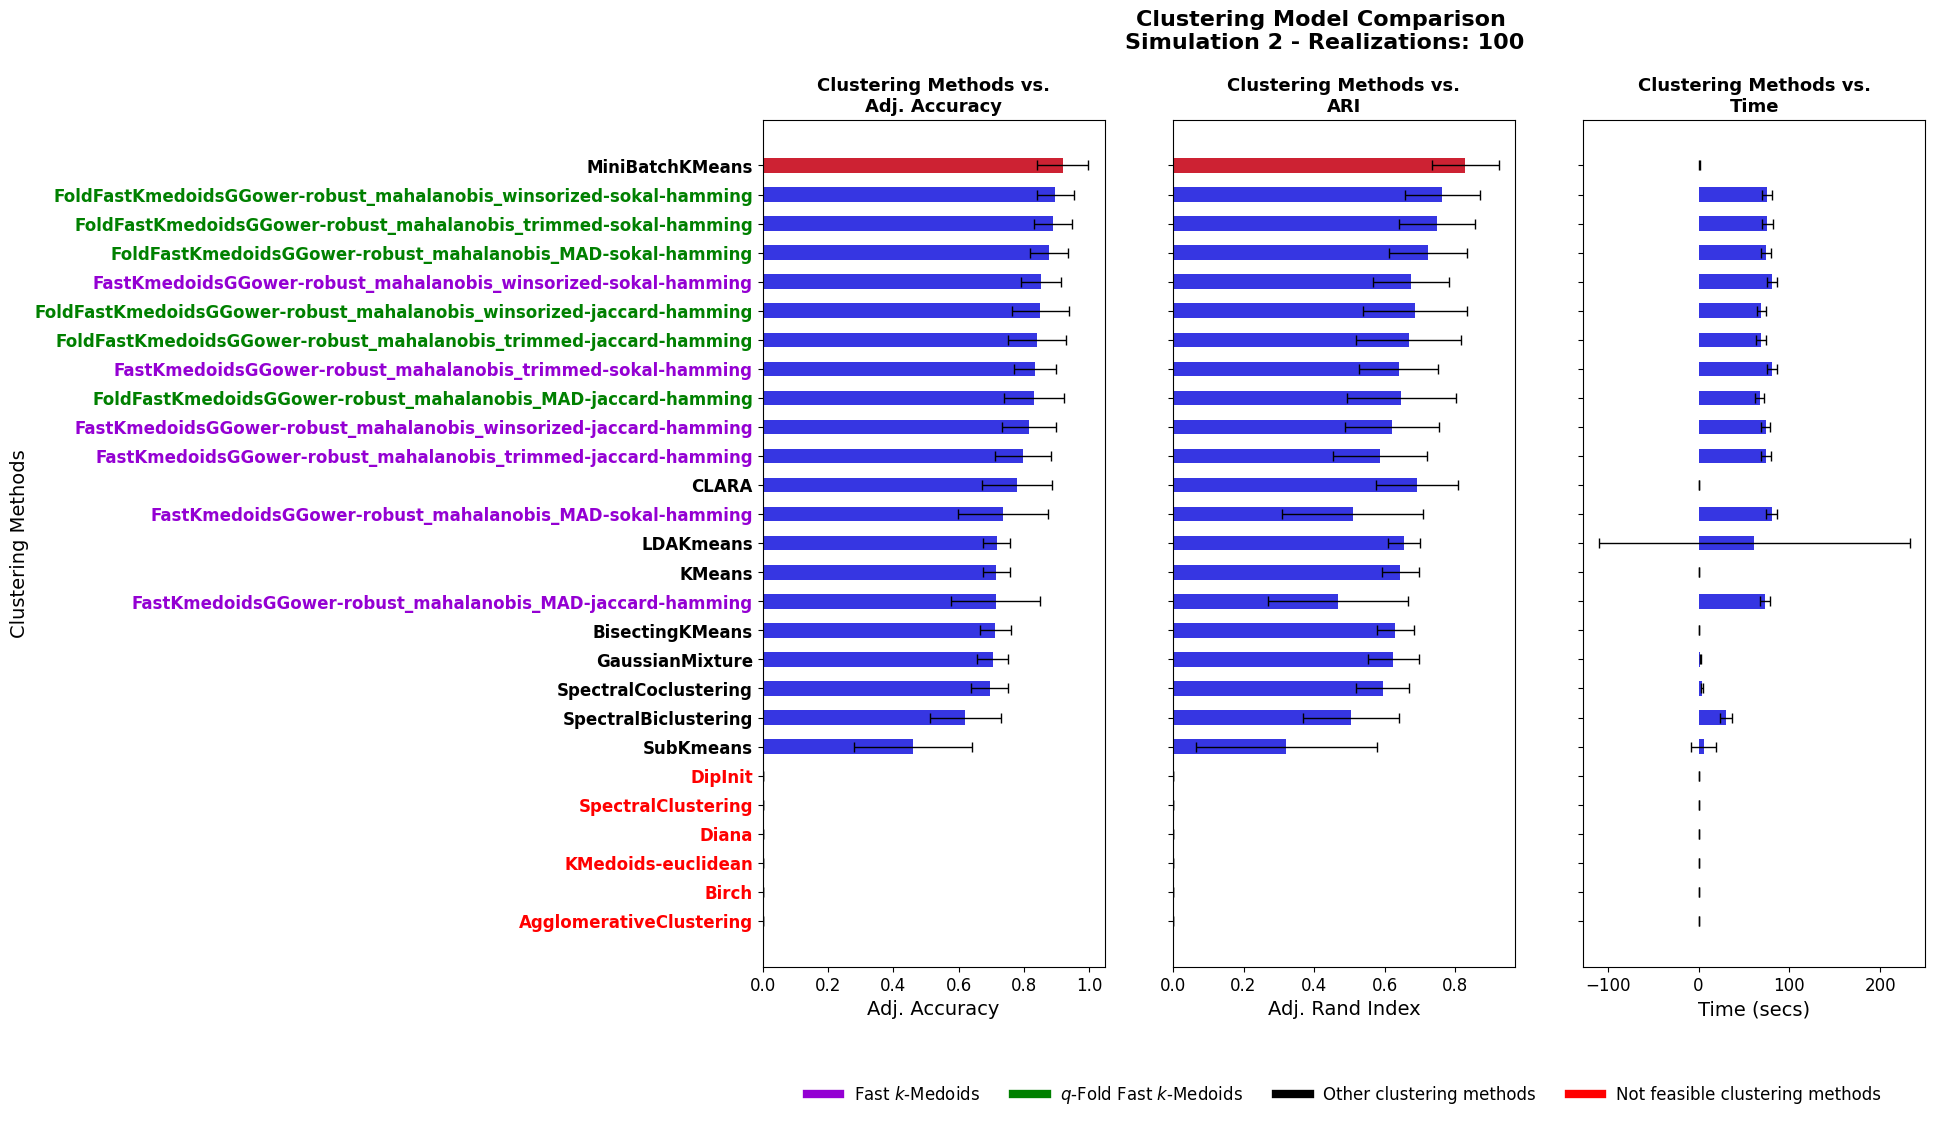

In [34]:
model_names = [x for x in df_avg['model_name'].unique().to_list()]
our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]
plot_filename = f'plot_results_exp_5_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

plot_experiment_5_results(
    df = df_avg, 
    data_name = DATA_ID, 
    num_realizations = 100, 
    save_path = save_path, 
    our_methods_1=our_methods_1, our_methods_2=our_methods_2, 
    other_methods=other_methods, not_feasible_methods=not_feasible_methods)

---
---

In [ ]:
def mds_plot_experiment_5():
    pass

# TODO

In [ ]:
random_state_mds = 75126  

X, y, outliers_idx = generate_simulation(
    random_state = random_state_mds,
    n_samples = simulation_config['n_samples'],
    centers = simulation_config['centers'],
    cluster_std = simulation_config['cluster_std'],
    n_features = simulation_config['n_features'],
    outlier_configs = simulation_config['outlier_configs'],
    custom_sampling = False,  
    return_outlier_idx=True
)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 
 
d1 = 'robust_mahalanobis'
d2 = 'jaccard'
d3 = 'hamming'
robust_method = 'trimmed'

np.random.seed(123)
sample_idx = np.random.choice(range(X.shape[0]), 300)

D = generalized_gower_dist_matrix(
        X=X[sample_idx,:], 
        p1=config_experiment['p1'], 
        p2=config_experiment['p2'], 
        p3=config_experiment['p3'], 
        d1=d1, d2=d2, d3=d3, 
        robust_method=robust_method, 
        alpha=config_experiment['alpha'], 
        epsilon=config_experiment['epsilon'], 
        n_iters=config_experiment['n_iters']
    )

X_mds = mds.fit_transform(D)

In [ ]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = df_avg['model_name'].to_list()

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


In [ ]:
plot_filename = f'mds_plot_exp_4_simu_1_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_1')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[sample_idx],
                                     title=f"Clustering Results Visualization with MDS - First Simulation (35k)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[sample_idx],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)